In [1]:
import shedding
from shedding.model import Model
import numpy as np
import tensorflow as tf
from tensorflow.experimental.numpy import logaddexp as tf_logaddexp
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import emcee
import tensorflow_probability as tfp
from scipy.special import expit, logit
from localscope import localscope
tfb = tfp.bijectors
tfd = tfp.distributions

Load data

In [2]:
# Load and flatten datasets (the other ones are a bit dodgy)
datasets = shedding.load_datasets([
    'Woelfel2020', 
    'Lui2020', 
    'Wang2020',
    'Han2020',
], 'publications/')
data = shedding.flatten_datasets(datasets, loq_fill_value=-99)
print(f'Number of patients: {data["num_patients"]}')
print(f'Number of patients with one or more positive samples: '
      f'{(data["num_positives_by_patient"] > 0).sum()}')
print(f'Number of samples: {data["num_samples"]}')
print(f'Number of positive samples: {data["positive"].sum()}')

Number of patients: 36
Number of patients with one or more positive samples: 27
Number of samples: 148
Number of positive samples: 104


Model

In [3]:
model = shedding.Model(data['num_patients'], inflated=True)
print(f'Number of parameters: {model.size}')

Number of parameters: 42


Initial parameters

In [12]:
# stack the initial parameters into an initial value
initial_params = {'population_shape': 0.515960576370487,
 'population_loc': 11.5565717463835,
 'population_scale': 3.47310178684614,
 'patient_shape': 0.614518235495056,
 'patient_scale': 3.28016164131799,
 'patient_mean': np.array([1.58109681e+06, 1.62960922e+05, 1.41395408e+06, 4.68819983e+06,
        4.74483035e+04, 6.84407824e+04, 2.67431684e+03, 9.97489948e+04,
        1.49190850e+02, 1.16571517e+04, 4.29331748e+04, 4.63699339e+03,
        7.62192130e+03, 1.15256383e+05, 7.73064475e+04, 1.05531632e+04,
        7.13806977e+05, 2.90353388e+06, 1.50283360e+05, 1.91588787e+04,
        1.32146734e+03, 2.11048180e+06, 1.28815061e+03, 1.84582526e+05,
        1.11418902e+03, 1.86133027e+04, 1.19827476e+03, 2.93958405e+04,
        1.29130768e+04, 1.46401627e+03, 1.18323499e+03, 1.13064256e+03,
        1.25157079e+03, 1.41620152e+05, 1.30795977e+05, 3.37467927e+07]),
  'rho':0.8}

#for key in initial_params.keys():
#    initial_params[key] = np.log(initial_params[key])
initial_params['population_shape'] = np.log(initial_params['population_shape'])
initial_params['patient_mean'] = np.log(initial_params['patient_mean'])
initial_params['rho'] = logit(0.8)
    
x_initial = np.concatenate([np.atleast_1d(initial_params[key]) for key in initial_params.keys()])

Log probability

In [13]:
@localscope
def evaluate_log_joint(x, model, data):
    
    values = shedding.vector_to_values(model.parameters, x)
    
    # Transform the bits that are logged (or whatever other transform)
    # Map the shape and scale parameters to the positive reals
    #keys = ['population_scale', 'population_shape', 'patient_shape', 'patient_scale']
    #values.update({key: np.exp(values[key]) for key in keys})
    values.update({'population_shape': np.exp(values['population_shape'])})
    values.update({'rho': 1./(1. + np.exp(-values['rho']))}) # expit for rho
    values.update({'log_patient_mean': values['patient_mean'],
                   'patient_mean': np.exp(values['patient_mean'])})
    
    log_prob = model.evaluate_log_joint(values, data) 
    log_prob += sum(values['log_patient_mean']) # jacobian term for the patient means (if using log)
    log_prob += np.log(values['rho']*(1.-values['rho'])) # jacobian for logit rho (if using logit)
    log_prob += np.log(values['population_shape']) # jacobian for populaiton shape (if using log)
    
    if np.isnan(log_prob):
        return -np.inf
    else:
        return log_prob

Do the sampling in emcee

In [14]:
n_walkers = 1000
n_params = x_initial.shape[0]
n_steps = 1000
x0 = x_initial + np.random.normal(0, 0.05, size=(n_walkers, x_initial.shape[0]))
sampler = emcee.EnsembleSampler(n_walkers, n_params, evaluate_log_joint, args=(model, data))
result = sampler.run_mcmc(x0, n_steps, progress=True)
chain_ = sampler.chain

100%|██████████| 1000/1000 [03:09<00:00,  5.28it/s]


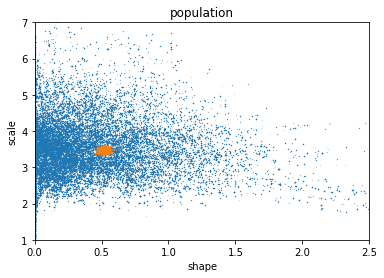

In [19]:
plt.scatter(np.exp(chain_[:,-100:,0].flatten()), chain_[:,-100:,2].flatten(), s = 0.01)
plt.scatter(np.exp(x0[:,0].flatten()), x0[:,2].flatten(), s = 0.1)
plt.ylim(1, 7)
plt.xlim(0, 2.5)
plt.title('population')
plt.ylabel('scale')
plt.xlabel('shape')
plt.show()

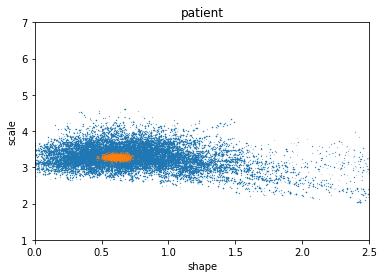

In [20]:
plt.scatter(chain_[:,-100:,3].flatten(), chain_[:,-100:,4].flatten(), s = 0.01)
plt.scatter(x0[:,3].flatten(), x0[:,4].flatten(), s = 0.1)
plt.ylim(1, 7)
plt.xlim(0, 2.5)
plt.title('patient')
plt.ylabel('scale')
plt.xlabel('shape')
plt.show()